In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from back import *
import pickle
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split

%matplotlib inline

## Data exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


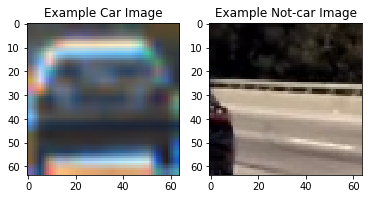

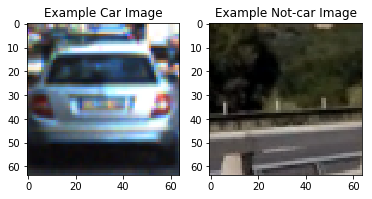

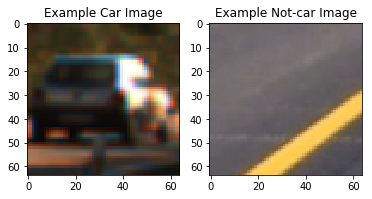

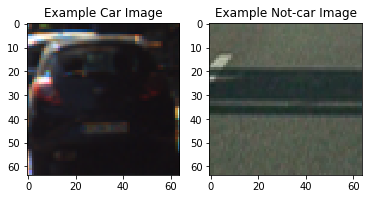

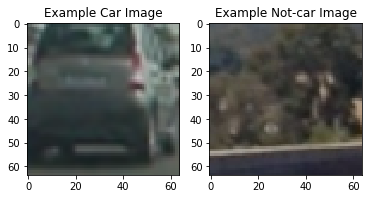

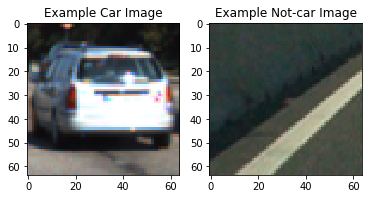

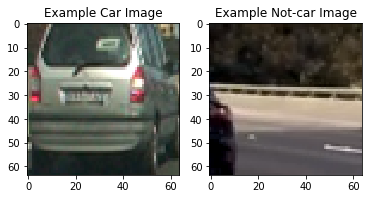

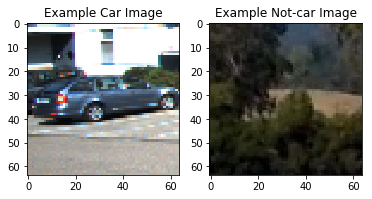

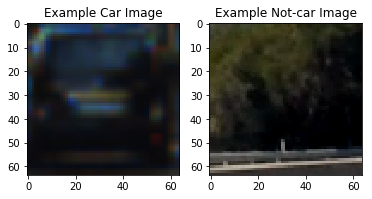

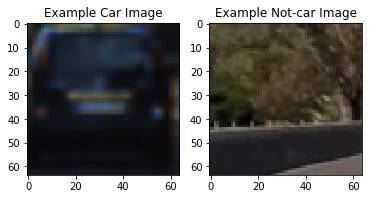

In [3]:
cars, notcars = read_images()
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

    
# Read in car / not-car images

for _ in range(10):
    
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))

    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

## HOG features

/Users/larionbabych/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


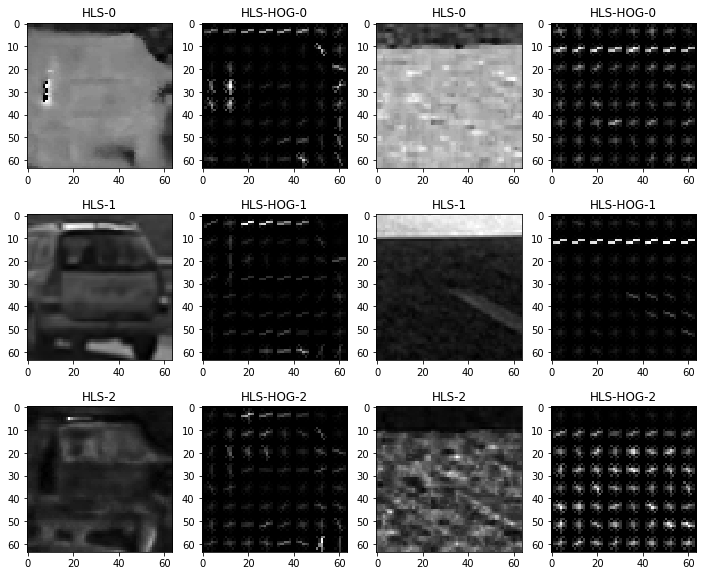

In [39]:
# Read in our vehicles and non-vehicles
cars, notcars = read_images()

# Generate a random index to look at a car image
# ind = np.random.randint(0, len(cars))
ind = 0
# Read in the car image
image = mpimg.imread(cars[ind])
car = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
# Read in the non car image 
image = mpimg.imread(notcars[ind])
notcar = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
# features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)

features0, car_hog0 = get_hog_features(car[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features1, car_hog1 = get_hog_features(car[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features2, car_hog2 = get_hog_features(car[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features0, noncar_hog0 = get_hog_features(notcar[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features1, noncar_hog1 = get_hog_features(notcar[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features2, noncar_hog2 = get_hog_features(notcar[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples

plt.figure(figsize=(12,10))

ax = plt.subplot(3,4,1)
ax.set_title('HLS-0')
plt.imshow(car[:,:,0], cmap='gray')
ax = plt.subplot(3,4,2)
ax.set_title('HLS-HOG-0')
plt.imshow(car_hog0, cmap='gray')

ax = plt.subplot(3,4,3)
ax.set_title('HLS-0')
plt.imshow(notcar[:,:,0], cmap='gray')
ax = plt.subplot(3,4,4)
ax.set_title('HLS-HOG-0')
plt.imshow(noncar_hog0, cmap='gray')

ax = plt.subplot(3,4,5)
ax.set_title('HLS-1')
plt.imshow(car[:,:,1], cmap='gray')
ax = plt.subplot(3,4,6)
ax.set_title('HLS-HOG-1')
plt.imshow(car_hog1, cmap='gray')

ax = plt.subplot(3,4,7)
ax.set_title('HLS-1')
plt.imshow(notcar[:,:,1], cmap='gray')
ax = plt.subplot(3,4,8)
ax.set_title('HLS-HOG-1')
plt.imshow(noncar_hog1, cmap='gray')

ax = plt.subplot(3,4,9)
ax.set_title('HLS-2')
plt.imshow(car[:,:,2], cmap='gray')
ax = plt.subplot(3,4,10)
ax.set_title('HLS-HOG-2')
plt.imshow(car_hog2, cmap='gray')

ax = plt.subplot(3,4,11)
ax.set_title('HLS-2')
plt.imshow(notcar[:,:,2], cmap='gray')
ax = plt.subplot(3,4,12)
ax.set_title('HLS-HOG-2')
plt.imshow(noncar_hog2, cmap='gray')


## Search and Classify

In [2]:
# Read in cars and notcars
cars, notcars = read_images()

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

/Users/daard/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


172.17 Seconds to extract features...
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1932
3.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


## Hog Sub-sampling Window Search

/Users/daard/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


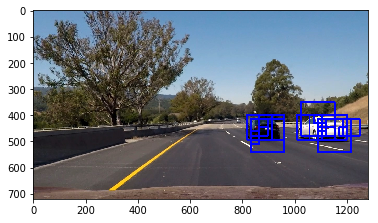

In [9]:
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_images/test6.jpg')

ystart = 350
ystop = 700
# scale = 1.5
   
draw_img = np.copy(img)

def find_windows(img, scale = 1.0):
    return find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# hot1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# hot_windows1 find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

hw0 = find_windows(img, 0.5)
hw1 = find_windows(img, 1.0)
hw2 = find_windows(img, 1.5)
hw3 = find_windows(img, 2)

tw = hw0 + hw1 + hw2 + hw3

for window in tw:
    cv2.rectangle(draw_img, window[0], window[1], (0, 0, 255), 6)

plt.imshow(draw_img)

## Multiple Detections & False Positives

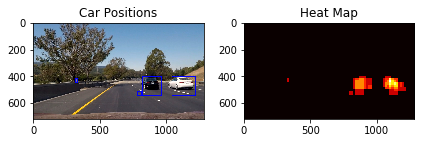

In [112]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load(open( "bbox_pickle.p", "rb" ))
box_list = tw

# Read in image similar to one shown above 
# image = mpimg.imread('test_images/test6.jpg')
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

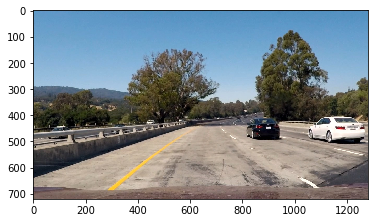

In [134]:
n=10

def pipeline(image):
    global crt_ind
    global heats
    hw0 = find_windows(image, 0.5)
    hw1 = find_windows(image, 1.0)
    hw2 = find_windows(image, 1.5)
    hw3 = find_windows(image, 2)

    box_list = hw0 + hw1 + hw2 + hw3
        
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    
    # save heat to global array
    indx = crt_ind % n
    heats[indx] = heat
    
    smoothed = np.zeros_like(heat).astype(np.float)
    for heati in heats:
        if heati is not None:
            smoothed += heati 
    
    
    smoothed = apply_threshold(smoothed, 0.7 * n)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(smoothed, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    crt_ind += 1
    return draw_img


image = mpimg.imread('test_images/test1.jpg')

crt_ind = 0
heats = [None for _ in range(n)]

out_img = pipeline(image)

plt.imshow(out_img)
    

In [135]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#clear cache
crt_ind = 0
heats = [None for _ in range(n)]

outvid = 'test_video_result.mp4'
clip = VideoFileClip("./test_video.mp4", audio=False)
detection_clip = clip.fl_image(pipeline)
%time detection_clip.write_videofile(outvid, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|█████████▋| 38/39 [01:37<00:02,  2.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

CPU times: user 1min 31s, sys: 6.84 s, total: 1min 37s
Wall time: 1min 38s


In [136]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outvid))

In [137]:
#clear cache
crt_ind = 0
heats = [None for _ in range(n)]

outvid = 'project_video_result.mp4'
clip = VideoFileClip("./project_video.mp4", audio=False)
detection_clip = clip.fl_image(pipeline)
%time detection_clip.write_videofile(outvid, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [55:51<00:02,  2.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 51min 21s, sys: 3min 57s, total: 55min 18s
Wall time: 55min 52s


In [138]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outvid))